In [ ]:
# %load_ext autoreload
# %autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

import sys
sys.path.append('../')

from matplotlib.colors import LogNorm
from src.viz import plot_trajectories, use_mpl_scatter_density
from src.io import load_dataframe, save_dataframe
from src.preprocessing import (compute_phases,split_trajectories,filter_trajectories,smooth_trajectory_savgol)
from src.embedding import Embedding
from src.embedding_position import EmbeddingPosition
from umap import UMAP
from src.preprocessing import reconstruct_trajectory_from_angles

from scipy.spatial import Voronoi, voronoi_plot_2d


ModuleNotFoundError: No module named 'k_means_constrained'

In [ ]:
df = pd.read_parquet('../data/toy_model/interim/phases.parquet')
df.head()

,x,y,z,label,frame,speed,curvature_angle,torsion_angle,abs_torsion_angle
0,-0.407268,0.758416,0.50886,1,1,1.0,0.000000e+00,1.570796,1.570796
1,-0.814536,1.516831,1.01772,1,2,1.0,1.490116e-08,1.570796,1.570796
2,-1.221804,2.275247,1.52658,1,3,1.0,0.000000e+00,-1.570796,1.570796
3,-1.629071,3.033663,2.03544,1,4,1.0,0.000000e+00,-1.570796,1.570796
4,-2.036339,3.792078,2.54430,1,5,1.0,0.000000e+00,1.570797,1.570797


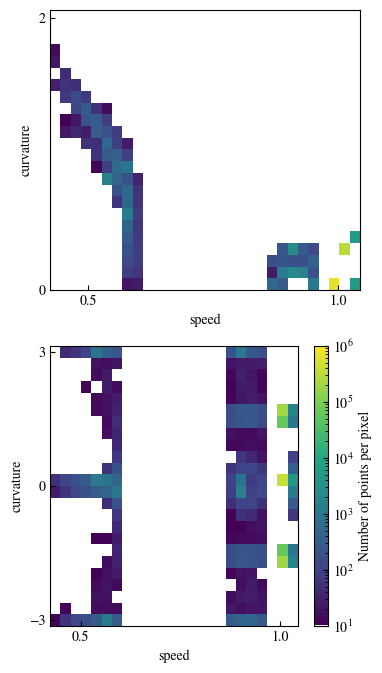

In [ ]:
#plt.scatter(df[df['label'] ==1]['speed'],df[df['label'] ==1]['curvature_angle'],marker='o',alpha=0.1)
fig = plt.figure(figsize=(4,8))
norm = LogNorm(vmin=1e1,vmax=10**6)
ax1 = use_mpl_scatter_density(fig, df['speed'],df['curvature_angle'],dpi=10,norm=norm,nrows=2,pos=1,colorbar=None)
ax1.set_xlabel('speed')
ax1.set_ylabel('curvature')
ax1.set_xticks([0.5,1.])
ax1.set_yticks([0.,2.])
#ax1.grid()
ax2 = use_mpl_scatter_density(fig, df['speed'],df['torsion_angle'],dpi=10,norm=norm,nrows=2,pos=2)
ax2.set_xlabel('speed')
ax2.set_ylabel('curvature')
ax2.set_xticks([0.5,1])
ax2.set_yticks([-3,0,3])
#ax2.grid()
#fig.savefig('phase_space_toy_model.svg',transparent=True,bbox_inches='tight')

In [5]:
emb = Embedding(df,
                columns=['speed','curvature_angle','torsion_angle'],
                ID_NAME='label')
#emb = Embedding(df,
#                columns=['speed','curvature_angle'],ID_NAME='label')

NameError: name 'Embedding' is not defined

In [3]:
emb.make_embedding(K=10)
emb.make_cluster(50)

NameError: name 'emb' is not defined

In [4]:
from k_means_constrained import KMeansConstrained

n_clusters = 50
size_min = 0.5 * emb.flatten_embedding_matrix.shape[0]/nclusters
size_max = 2 * emb.flatten_embedding_matrix.shape[0]/nclusters

km = KMeansConstrained(
    n_clusters=K,
    size_min=desired_min_size,
    size_max=desired_max_size,
    random_state=0
)
labels = km.fit(emb.flatten_embedding_matrix)
cluster_centers_ = km.cluster_centers_


NameError: name 'emb' is not defined

0
0


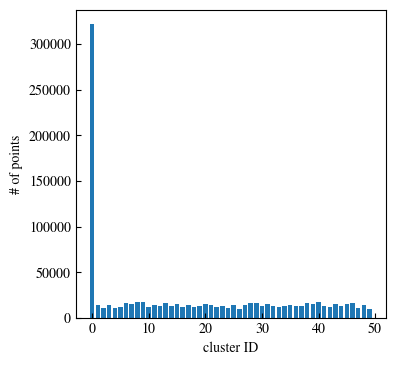

In [68]:
# look at the distribution of points in the clusters
unique_labels, counts = np.unique(emb.labels, return_counts=True)
# Optionally, zip into a dict
cluster_counts = dict(zip(unique_labels, counts))
fig,ax = plt.subplots(figsize=(4,4))
ax.bar(list(cluster_counts.keys()),list(cluster_counts.values()))
ax.set_xlabel('cluster ID')
ax.set_ylabel('# of points')
print(unique_labels[np.argmax(counts)])
print(np.argmax(counts))

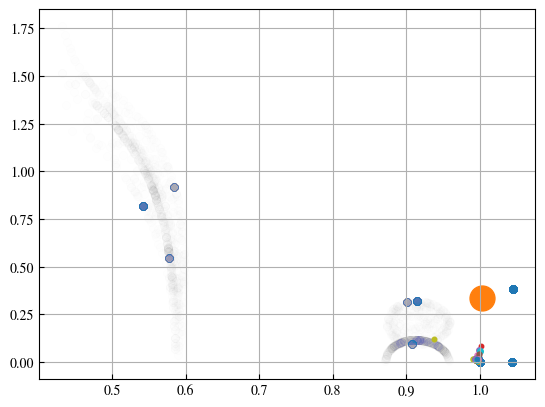

In [69]:
#ax = plt.subplot(projection="3d")
#ax.scatter(emb.flatten_embedding_matrix[:,0],emb.flatten_embedding_matrix[:,1],emb.flatten_embedding_matrix[:,2],alpha=0.01)
plt.scatter(emb.flatten_embedding_matrix[:100000,0],emb.flatten_embedding_matrix[:100000,1],alpha=0.002)
for i in range(emb.cluster_centers_.shape[0]):
    plt.scatter(emb.cluster_centers_[i,0],emb.cluster_centers_[i,1],s=counts[i]/1000)
plt.grid()

In [70]:
rng = np.random.default_rng(10973)
indices = rng.choice(emb.flatten_embedding_matrix.shape[0], size=1000, replace=False)
data = emb.flatten_embedding_matrix[indices]
    
combined =np.array([])
# Concatenate data and centers before UMAP
combined = np.append(data, emb.cluster_centers_, axis=0)

In [71]:
reducer = UMAP(
        n_neighbors=100,
        min_dist=0.1,
        n_components=2,
        metric="euclidean",
    )
reduced_all = reducer.fit_transform(combined)

In [72]:
N = data.shape[0]
reduced_points = reduced_all[:N]
reduced_centers = reduced_all[N:N + emb.cluster_centers_.shape[0]]

/mnt/hcleroy/anaconda3/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/mnt/hcleroy/anaconda3/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


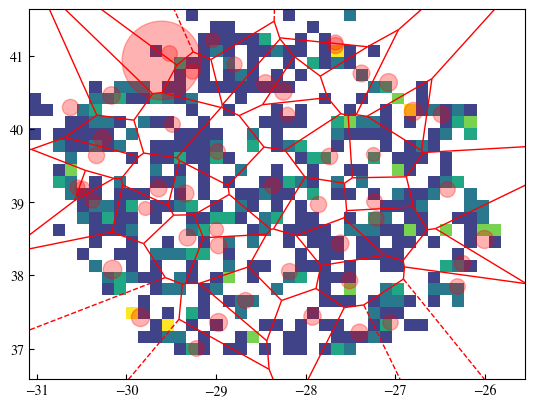

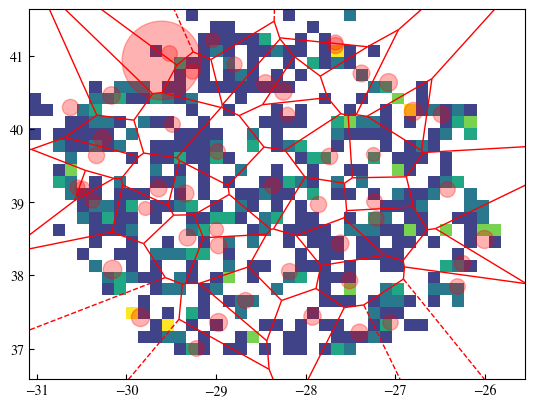

In [73]:
fig = plt.figure()
#ax.scatter(reduced_points[:,0],reduced_points[:,1])
ax = use_mpl_scatter_density(fig, reduced_points[:,0],reduced_points[:,1],dpi=10,nrows=1,pos=1,colorbar=None)
for i in range(reduced_centers.shape[0]):
    ax.scatter(reduced_centers[i,0],reduced_centers[i,1],s=counts[i]*0.01,color="red", alpha=0.3)
    
vor = Voronoi(reduced_centers)
voronoi_plot_2d(vor, ax=ax, show_points = False, show_vertices=False, line_colors='red')

In [428]:
#ax = plt.subplot(projection="3d")
#speed, theta,torsion = emb.cluster_centers_[78][0::3],emb.cluster_centers_[78][1::3],emb.cluster_centers_[78][2::3]
#traj = reconstruct_trajectory_from_angles(np.array([speed,theta,torsion]).T)
#ax.plot(traj[:,0],traj[:,1],traj[:,2])

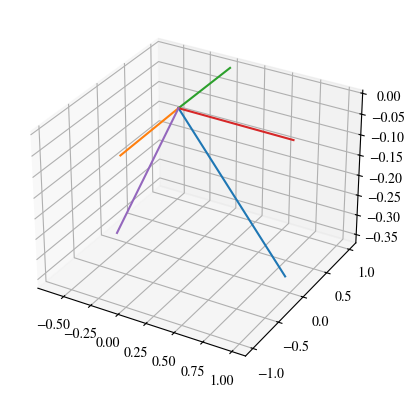

In [429]:
ax = plt.subplot(projection="3d")
for i in range(emb.cluster_centers_.shape[0]):
    speed, theta,torsion = emb.cluster_centers_[i][0::3],emb.cluster_centers_[i][1::3],emb.cluster_centers_[i][2::3]
    traj = reconstruct_trajectory_from_angles(np.array([speed,theta,torsion]).T)
    ax.plot(traj[:,0],traj[:,1],traj[:,2])

In [430]:
emb.make_transition_matrix(tau=1)
state_trajectory = list()
emb.initialize_state()
state_trajectory.append(emb.state)
for i in range(50):
    emb.make_transition()
    state_trajectory.append(emb.state)
state_trajectory=np.array(state_trajectory)

In [431]:
phase_trajectory = list()
for points in state_trajectory:
    phase_trajectory.append(emb.pick_random_trajectory_in_cluster(points))
phase_trajectory = np.array(phase_trajectory)

In [432]:
speed, theta,torsion = phase_trajectory.flatten()[0::3],phase_trajectory.flatten()[1::3],phase_trajectory.flatten()[2::3]
traj = reconstruct_trajectory_from_angles(np.array([speed,theta,torsion]).T)
#speed, theta,torsion = phase_trajectory.flatten()[0::2],phase_trajectory.flatten()[1::2]
#traj = reconstruct_trajectory_from_angles(np.array([speed,theta]).T)

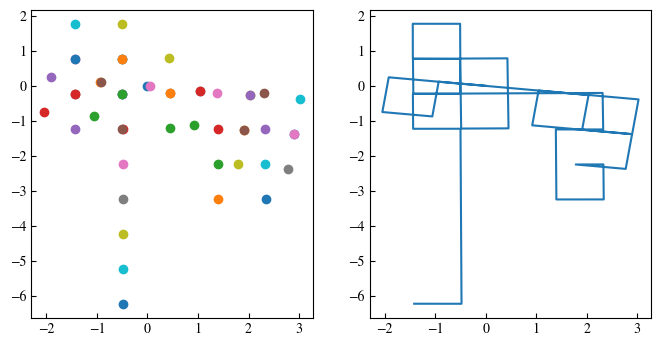

In [433]:
fig,ax = plt.subplots(ncols=2,figsize=(8,4))
tint = phase_trajectory.shape[1]//2 # phase_trajectory.shape[1] contains x and y
for i in range(phase_trajectory.shape[0]):
    ax[0].plot(traj[i*tint:(i+1)*tint,0],traj[i*tint:(i+1)*tint,1],marker='o')
ax[1].plot(traj[:,0],traj[:,1])

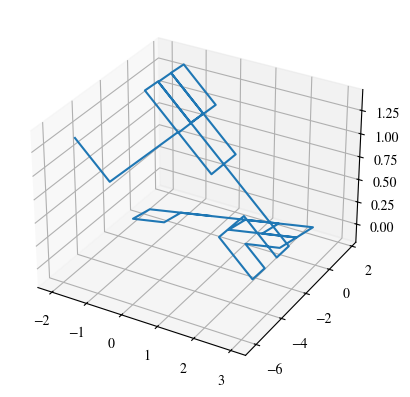

In [434]:
ax = plt.subplot(projection='3d')
ax.plot(traj[:,0],traj[:,1],traj[:,2])

In [335]:
df1 = pd.read_csv('../data/toy_model/interim/longest_trajectory.csv')
df1.head()

,x,y,z,label,frame,speed,curvature_angle,torsion_angle,abs_torsion_angle
0,2.929049,1.132753,0.139303,0,1,1.047904,0.393285,0.067051,0.067051
1,2.365123,1.951153,0.265286,0,2,1.003702,0.275906,-0.398100,0.398100
2,1.607666,2.584064,0.457275,0,3,1.008354,0.300475,-0.030763,0.030763
3,0.683506,2.972553,0.589183,0,4,1.012413,0.357366,0.422935,0.422935
4,-0.328206,3.025995,0.623126,0,5,1.004846,0.398219,0.186152,0.186152


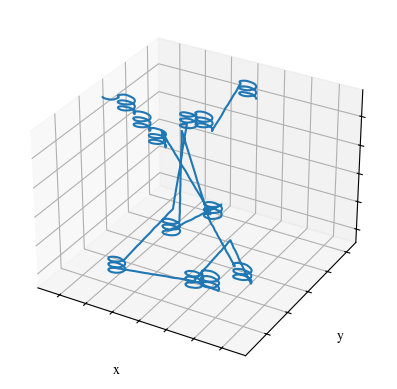

In [444]:
ax = plt.subplot(projection='3d')
ax.plot(df1['x'],df1['y'],df1['z'])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.grid(True)
plt.savefig('toy_trajectory.svg',transparent=True,bbox_inches='tight')
